In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
class cosmo:
    def __init__(self, data):
        self.data = data
    
    def salt2_model(self,theta):
        M, alpha, beta, sigma=theta

        Om= 0.34334826
        
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
        
        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        sigmalens=0.055*self.data["z"]
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        return -lnlike
    
    def salt2_model_w_bias_cor(self,theta):
        M, alpha, beta, sigma=theta
        
        Om= 0.34334826

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
                
        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        biascor=self.data["biasCor_mB"]-beta*self.data["biasCor_c"]+alpha*self.data["biasCor_x1"]
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        sigmalens=0.055*self.data["z"]
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model-biascor)**2./sigma2 + np.log(2*np.pi*sigma2))

        return -lnlike
    
    def salt2_model_w_gamma(self,theta):
        M, alpha, beta, gamma, sigma=theta
        
        Om= 0.34334826

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]-2.5*np.log10(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"])
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        fator=-2.5*np.log10(np.e)/(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"])
        cov=2.*(-alpha-gamma*self.data["c"])*self.data["cov_mB_x1"]*fator+2.*(beta-gamma*self.data["x1"])*self.data["cov_mB_c"]*fator+2.*(-alpha-gamma*self.data["c"])*(beta-gamma*self.data["x1"])*self.data["cov_x1_c"]*fator**2.
        sigmalens=0.055*self.data["z"]        
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+((-alpha-gamma*self.data["c"])**2.*self.data["x1err"]**2+(beta-gamma*self.data["x1"])**2.*self.data["cerr"]**2.)*fator**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))

        return -lnlike
    
    def salt2_model_w_new_par(self,theta):
        M, alpha, beta, gamma, delta, tau, sigma=theta
        
        Om= 0.34334826

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]-2.5*np.log10(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"]+delta*self.data["c"]**2-tau*self.data["x1"]*self.data["c"]**2)
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        fator=-2.5*np.log10(np.e)/(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"]+delta*self.data["c"]**2-tau*self.data["x1"]*self.data["c"]**2)
        cov=2.*(-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)*self.data["cov_mB_x1"]*fator+2.*(beta-gamma*self.data["x1"]+2*delta*self.data["c"])*self.data["cov_mB_c"]*fator+2.*(-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)*(beta-gamma*self.data["x1"]+2*delta*self.data["c"])*self.data["cov_x1_c"]*fator**2.
        sigmalens=0.055*self.data["z"]        
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+((-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)**2.*self.data["x1err"]**2+(beta-gamma*self.data["x1"]+2*delta*self.data["c"])**2.*self.data["cerr"]**2.)*fator**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))

        return -lnlike

## Carregando dados

In [3]:
pant=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

In [4]:
cov_mB_x1=-2.5*np.log10(np.e)/pant["x0"]*pant["COV_x1_x0"]
cov_mB_c=-2.5*np.log10(np.e)/pant["x0"]*pant["COV_c_x0"]

In [5]:
data=pant[["zCMB","zCMBERR","mB","mBERR","x1","x1ERR","c","cERR","COV_x1_c","biasCor_mB","biasCor_x1","biasCor_c"]]

In [6]:
data.insert(9, "cov_mB_x1",cov_mB_x1, True)
data.insert(10, "cov_mB_c",cov_mB_c, True)

In [7]:
data.columns=["z","zerr","mB","mBerr","x1","x1err","c","cerr","cov_x1_c","cov_mB_x1","cov_mB_c","biasCor_mB","biasCor_x1","biasCor_c"]

In [8]:
data_sorted=data.sort_values(by=["z"]).reset_index(drop=True)

In [9]:
np.linspace(0.,.4,15)

array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
       0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
       0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ])

In [10]:
np.linspace(0.4,1.,5)

array([0.4 , 0.55, 0.7 , 0.85, 1.  ])

In [34]:
red_bins=np.concatenate((np.linspace(0.,0.05,2),np.linspace(0.05,0.15,2)[1:],np.linspace(0.15,0.25,3)[1:],np.linspace(0.25,0.4,3)[1:],np.linspace(0.4,0.6,2)[1:],np.linspace(0.6,0.8,2)[1:]),axis=0)

In [12]:
red_binned_data=dict()

(array([105.,  59.,  27.,  19.,  32.,  44.,  44.,  58.,  54.,  45.,  59.,
         45.,  45.,  37.,  35.,  29.,  28.,  13.,  20.,  13.,  18.,   8.,
         14.,   8.,   9.,  18.,   7.,  11.,   5.,   6.,  13.,   7.,  15.,
         11.,   3.,  11.,   8.,   8.,   5.,   4.,   8.,   7.,   5.,   5.,
          3.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   2.,
          0.,   0.,   2.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00931  , 0.0318169, 0.0543238, 0.0768307, 0.0993376, 0.1218445,
        0.1443514, 0.1668583, 0.1893652, 0.2118721, 0.234379 , 0.2568859,
        0.2793928, 0.3018997, 0.3244066, 0.3469135, 0.3694204, 0.3919273,
        0.4144342, 0.4369411, 0.459448 , 0.4819549, 0.5044618, 0.5269687,
        0.5494756, 0.5

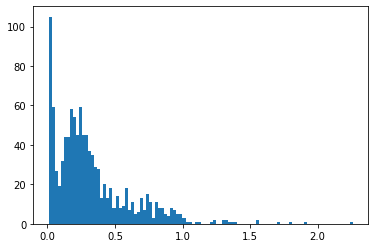

In [13]:
plt.hist(data_sorted["z"],bins=100)

In [36]:
for i in range(8):
    print((red_bins[i],red_bins[i+1])) # 6 intervalos
    red_binned_data[i]=data_sorted[(data_sorted["z"]>red_bins[i]) & (data_sorted["z"]<=red_bins[i+1])].reset_index(drop=True)
    print(len(red_binned_data[i]))

(0.0, 0.05)
157
(0.05, 0.15)
140
(0.15, 0.2)
114
(0.2, 0.25)
120
(0.25, 0.325)
142
(0.325, 0.4)
93
(0.4, 0.6)
120
(0.6, 0.8)
80


#### Scipy Minimization

In [15]:
x0 = [0.3,24.,0.15,3.5,0.1] # NÃO ESQUECER DE TROCAR O VALOR DO LNLIKE RETORNADO

In [16]:
res = minimize(cosmo_salt2.salt2_model, x0, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True})

NameError: name 'cosmo_salt2' is not defined

In [17]:
res.x

NameError: name 'res' is not defined

#### Minimizando para cada bin de redshift SALT2

In [37]:
x0 = [24.,0.15,3.5,0.1]

In [38]:
M_red_dep=[]
alpha_red_dep=[]
beta_red_dep=[]
sig_int_red_dep=[]

In [39]:
for i in range(8):
    #print(len(red_binned_data[i]))
    cosmo_binned=cosmo(red_binned_data[i])
    res = minimize(cosmo_binned.salt2_model, x0, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': False})
    M_red_dep.append(res.x[0])
    alpha_red_dep.append(res.x[1])
    beta_red_dep.append(res.x[2])
    sig_int_red_dep.append(res.x[3])

In [40]:
red_mean=[]
for i in range(8):
    red_mean.append(np.mean([red_bins[i],red_bins[i+1]]))

Text(0, 0.5, '$\\alpha$')

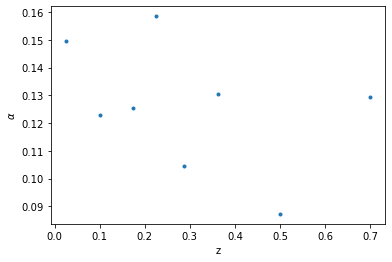

In [41]:
plt.plot(red_mean,np.array(alpha_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\alpha$")

Text(0, 0.5, '$\\beta$')

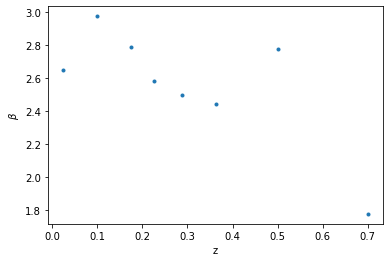

In [42]:
plt.plot(red_mean,np.array(beta_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\beta$")

Text(0, 0.5, '$\\mathcal{M}$')

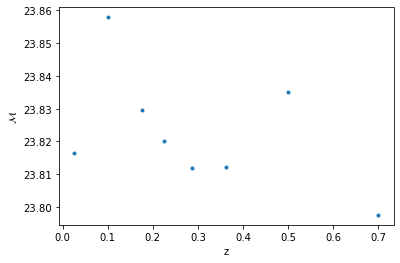

In [43]:
plt.plot(red_mean,np.array(M_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\mathcal{M}$")

Text(0, 0.5, '$\\sigma_{int}$')

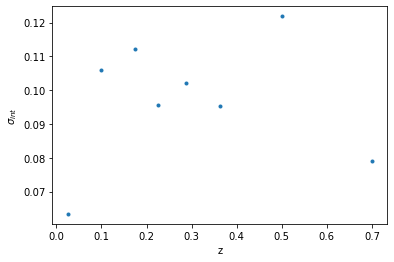

In [44]:
plt.plot(red_mean,np.array(sig_int_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\sigma_{int}$")

#### Minimizando para cada bin de redshift SALT2 correção de bias

In [22]:
x0 = [24.,0.15,3.5,0.1]

In [23]:
M_red_dep=[]
alpha_red_dep=[]
beta_red_dep=[]
sig_int_red_dep=[]

In [24]:
for i in range(10):
    #print(len(red_binned_data[i]))
    cosmo_binned=cosmo(red_binned_data[i])
    res = minimize(cosmo_binned.salt2_model_w_bias_cor, x0, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': False})
    M_red_dep.append(res.x[0])
    alpha_red_dep.append(res.x[1])
    beta_red_dep.append(res.x[2])
    sig_int_red_dep.append(res.x[3])

In [25]:
red_mean=[]
for i in range(10):
    red_mean.append(np.mean([red_bins[i],red_bins[i+1]]))

Text(0, 0.5, '$\\alpha$')

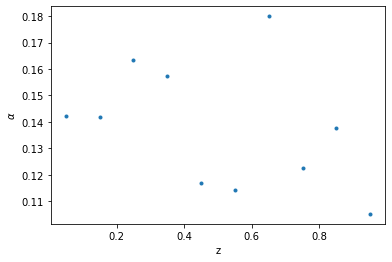

In [26]:
plt.plot(red_mean,np.array(alpha_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\alpha$")

Text(0, 0.5, '$\\beta$')

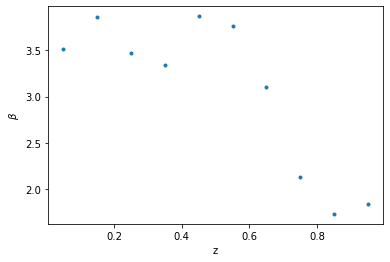

In [27]:
plt.plot(red_mean,np.array(beta_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\beta$")

Text(0, 0.5, '$\\mathcal{M}$')

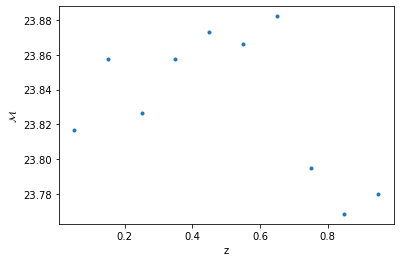

In [28]:
plt.plot(red_mean,np.array(M_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\mathcal{M}$")

Text(0, 0.5, '$\\sigma_{int}$')

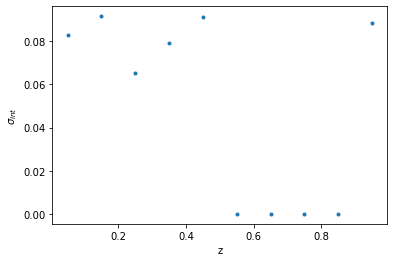

In [29]:
plt.plot(red_mean,np.array(sig_int_red_dep),'.')
plt.xlabel("z")
plt.ylabel(r"$\sigma_{int}$")